# Price Forecast for New York Airbnb

## Programming Language: R
## Data Preprocessing

- Select useful variables to make prediction.
- Data preprocessing: convert data type, replace NA value, take out outliers.

In [14]:
df <- read.csv("AB_NYC_2019.csv")
head(df)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,X,X.1,X.2
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018/10/19,0.21,6,365,NA,NA,NA
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019/5/21,0.38,2,355,NA,NA,NA
3,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Private room,150,3,0,,,1,365,NA,NA,NA
4,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019/7/5,4.64,1,194,NA,NA,NA
5,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018/11/19,0.1,1,0,NA,NA,NA
6,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.975,Entire home/apt,200,3,74,2019/6/22,0.59,1,129,NA,NA,NA


- price, minimum nights, number of reviews, reviews per month those should be numeric but now is character.
- convert from character to number.
- neighbourhood_group, room_type convert to factor.

In [15]:
library(tidyverse)
df <- df %>% select(neighbourhood_group, room_type, price, minimum_nights, number_of_reviews, reviews_per_month)

head(df) # 48576 total obs.

df$neighbourhood_group <- as.factor(df$neighbourhood_group)
df$room_type <- as.factor(df$room_type)
df$price <- as.numeric(df$price)
df$minimum_nights <- as.numeric(df$minimum_nights)
df$number_of_reviews <- as.numeric(df$number_of_reviews)
df$reviews_per_month <- as.numeric(df$reviews_per_month)

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Brooklyn,Private room,149,1,9,0.21
2,Manhattan,Entire home/apt,225,1,45,0.38
3,Manhattan,Private room,150,3,0,
4,Brooklyn,Entire home/apt,89,1,270,4.64
5,Manhattan,Entire home/apt,80,10,9,0.1
6,Manhattan,Entire home/apt,200,3,74,0.59


Warning message in eval(expr, envir, enclos):
"強制變更過程中產生了 NA"
Warning message in eval(expr, envir, enclos):
"強制變更過程中產生了 NA"
Warning message in eval(expr, envir, enclos):
"強制變更過程中產生了 NA"
Warning message in eval(expr, envir, enclos):
"強制變更過程中產生了 NA"


- Insert median to replace 'NA' value because I think mean will impact by outlier, I choose median.

In [16]:
for (i in 1:nrow(df)){
    if (is.na(df$price[i])){
    df$price[i] = median((df %>% filter(price!='NA'))$price)
    }}

for (i in 1:nrow(df)){
    if(is.na(df$number_of_reviews[i])){
        df$number_of_reviews[i] = median((df %>% filter(number_of_reviews!='NA'))$number_of_reviews)
    }}

for (i in 1:nrow(df)){
    if(is.na(df$reviews_per_month[i])){
        df$reviews_per_month[i] = median((df %>% filter(reviews_per_month!='NA'))$reviews_per_month)
    }}

for (i in 1:nrow(df)){
    if (is.na(df$minimum_nights[i])){
    df$minimum_nights[i] = median((df %>% filter(minimum_nights!='NA'))$minimum_nights)
    }}

In [17]:
colSums(is.na(df))

neighbourhood_group           room_type               price      minimum_nights 
                  0                   0                   0                   0 
  number_of_reviews   reviews_per_month 
                  0                   0

- Check outliers. Beyond the range of -1.5*IQR to 1.5*IQR

In [18]:
# Calculate % of outliers using interquartile range method
outlier_per <- function(x){
    lowerq = quantile(x)[2]
    upperq = quantile(x)[4]
    iqr = upperq - lowerq
    threshold_upper = (iqr * 1.5) + upperq
    threshold_lower = lowerq - (iqr * 1.5)
    count <- length(which(x > threshold_upper | x < threshold_lower))
    per <- count/length(x)
    result <- per*100
    result
}

In [19]:
df_num = df %>% select(price, minimum_nights, number_of_reviews, reviews_per_month)
X_num <- ncol(df_num)

for (i in 1:X_num) {
    colname <- colnames(df[i])
    outliers <- round(outlier_per(df_num[,i]),2)
    cat(colname,":", outliers,"% ")
}

neighbourhood_group : 6.05 % room_type : 13.76 % price : 12.7 % minimum_nights : 8.36 % 

- Extract outliers to other group

In [20]:
## price ##
lowerq <- quantile(df[,3])[2]
upperq <- quantile(df[,3])[4]
iqr = upperq - lowerq
threshold_upper = (iqr * 1.5) + upperq
threshold_lower = lowerq - (iqr * 1.5)

# find which rows are outliers
p <- c()
p <- which(df[,3] > threshold_upper | df[,3] < threshold_lower)

# extract to other group
df_outlier <- df[p, ]
df <- df[-p, ]

## minimum_nights ##
lowerq <- quantile(df[,4])[2]
upperq <- quantile(df[,4])[4]
iqr = upperq - lowerq
threshold_upper = (iqr * 1.5) + upperq
threshold_lower = lowerq - (iqr * 1.5)

# find which rows are outliers
p <- c()
p <- which(df[,4] > threshold_upper | df[,4] < threshold_lower)

# extract to other group
df_outlier <- rbind(df_outlier, df[p, ])
df <- df[-p, ]

## number_of_reviews ##
lowerq <- quantile(df[,5])[2]
upperq <- quantile(df[,5])[4]
iqr = upperq - lowerq
threshold_upper = (iqr * 1.5) + upperq
threshold_lower = lowerq - (iqr * 1.5)

# find which rows are outliers
p <- c()
p <- which(df[,5] > threshold_upper | df[,5] < threshold_lower)

# extract to other group
df_outlier <- rbind(df_outlier, df[p, ])
df <- df[-p, ]

## reviews_per_month ##
lowerq <- quantile(df[,6])[2]
upperq <- quantile(df[,6])[4]
iqr = upperq - lowerq
threshold_upper = (iqr * 1.5) + upperq
threshold_lower = lowerq - (iqr * 1.5)

# find which rows are outliers
p <- c()
p <- which(df[,6] > threshold_upper | df[,6] < threshold_lower)

# extract to other group
df_outlier <- rbind(df_outlier, df[p, ])
df <- df[-p, ]

In [21]:
cat('df:',dim(df))
cat('\ndf_outliers:',dim(df_outlier))

df: 31104 6
df_outliers: 17472 6

- we can do some research on outliers in future, but now we are focusing on remain data.

## Split Data

In [24]:
# convert neighbourhood_group, room_type to numeric.
df$neighbourhood_group <- as.numeric(df$neighbourhood_group)
df$room_type <- as.numeric(df$room_type)

In [26]:
# split data
set.seed(1)
n = nrow(df)
z = sample(n, n*0.8)

train_df = df[z,]
test_df = df[-z,]

## Fit Linear Regression

In [27]:
train_reg_df <- lm(price~., data= train_df)

Yhat= predict(train_reg_df, test_df)
Y= test_df$price
MSE= mean((Y-Yhat)^2)
MSE

[1] 4453.323

## KNN

In [28]:
library(class)
xtrain = train_df %>% select(neighbourhood_group, room_type, minimum_nights, number_of_reviews, reviews_per_month)
xtrain = scale(xtrain)
xtrain = data.frame(xtrain)
ytrain = train_df %>% select(price)

xtest = test_df %>% select(neighbourhood_group, room_type, minimum_nights, number_of_reviews, reviews_per_month)
xtest = scale(xtest)
xtest = data.frame(xtest)
ytest = test_df %>% select(price)


Attaching package: 'FNN'


The following objects are masked from 'package:class':

    knn, knn.cv




[1] 20

[1] 2856.378

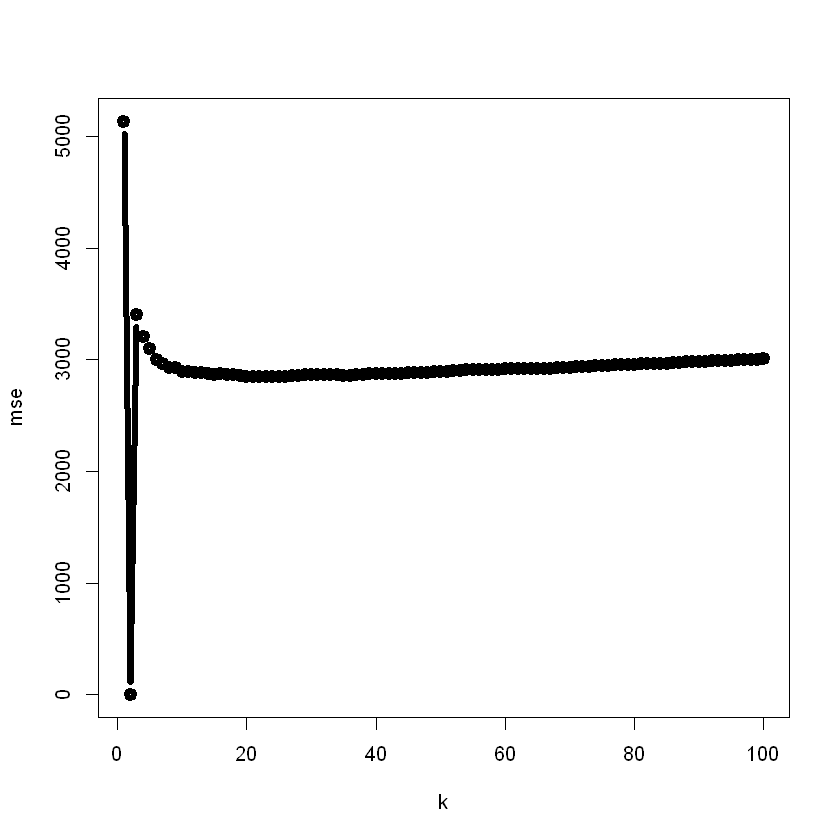

In [29]:
# choose K
library(FNN)
mse = rep(0,100) # calculate error for each K

# k= 1
yhat = knn.reg(xtrain, xtest, ytrain, 1)
yhat = yhat$pred
Y= ytest[,1]
mse[1] = mean((Y-yhat)^2)

# k= 3~100
for (k in 3:100){ # k=2 has Error in as.matrix(x)[i] : subscript out of bounds.
  yhat = knn.reg(xtrain, xtest, ytrain, k)
  yhat = yhat$pred
  Y= ytest[,1]
  mse[k] = mean((Y-yhat)^2)
}

k= 1:100
plot(k, mse, type="b", lwd=5)
which.min(mse[-2]) # K= 20 is lowest
mse[20]

## Decision Tree

In [30]:
# Error in tree(price ~ ., data = train_df) : factor predictors must have at most 32 levels.
# We can use cluster to fix it. But now we just we our converted numeric variables.

Registered S3 method overwritten by 'tree':
  method     from
  print.tree cli 



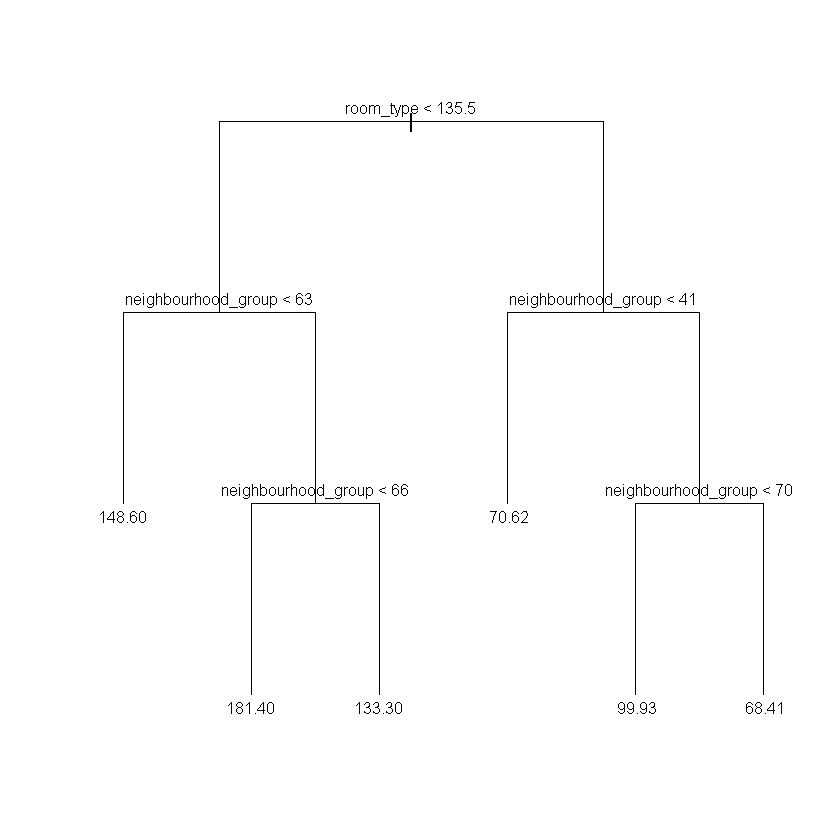

In [31]:
library(tree)
ab.tree <- tree(price ~., data= train_df) ## mindev default value is 0.01
                                          ## higher mindev will have smaller tree
plot(ab.tree,type = "uniform")
text(ab.tree,cex=0.8)

In [32]:
best.mindev <- -1
MSE <- -1
best.MSE <- 99999999
for (i in 1:100) {
  ab.tree <- tree(price ~., data= train_df, mindev=0.0005*i)
  ab.tree.predictions <- predict(ab.tree, test_df)
  
  MSE <- mean((test_df$price- ab.tree.predictions)^2)
  
  if (MSE < best.MSE) {
    best.mindev <- 0.0005*i
    best.MSE <- MSE
  }
}
print(paste("The optimal value of mindev is",best.mindev,"with a MSE of",best.MSE))

[1] "The optimal value of mindev is 5e-04 with a MSE of 2560.49309615225"


## Result

- After fitting three different models, I select Decision Tree to be best model with lowest MSE. In the future, we can try to dig more information in outliers group. Also, we can try to use cluster to fix tree model's problem.